## Predicting the average SAT score for Public High Schools
**This notebook explores predicting the average SAT score for public high schools in North Carolina.** 
* Public school racial compositions are also considered when making predictions in this notebook.
* The North Carolina Educational Attainment Data Repository for Machine Learning is located on Github at: https://github.com/jakemdrew/EducationDataNC 

**For documentation on various Generalized Linear Models in Sklearn see:**
* http://scikit-learn.org/stable/modules/linear_model.html
* https://stackoverflow.com/questions/33845539/modelling-probabilities-in-a-regularized-logistic-regression-model-in-python

In [1]:
#import required Libraries
import pandas as pd
import numpy as np

#The 'path' variable may also be a URL pointing to the proper raw file path on github: 
#path="https://raw.githubusercontent.com/jakemdrew/EducationDataNC/master/2017/Machine%20Learning%20Datasets/PublicHighSchools2017_ML.csv"

path="C:/Users/Jake/Documents/GitHub/EducationDataNC/2017/Machine Learning Datasets/PublicHighSchools2017_ML.csv"
schData=pd.read_csv(path, low_memory=False)

#inspect data 
schData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 470 entries, 0 to 469
Columns: 403 entries, student_num to unit_code
dtypes: float64(322), int64(81)
memory usage: 1.4 MB


In [2]:
SATCols = schData.columns[schData.columns.str.lower().str.contains('sat')]
SATCols

Index([u'sat_avg_score_num', u'lea_sat_avg_score_num',
       u'sat_participation_pct', u'lea_sat_participation_pct'],
      dtype='object')

In [3]:
# create x explanatory and y response variables for regression
Y_SAT = schData['sat_avg_score_num']
X_highSchools = schData.drop(['sat_avg_score_num'], axis=1)

Y = Y_SAT

#inspect data 
X_highSchools.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 470 entries, 0 to 469
Columns: 402 entries, student_num to unit_code
dtypes: float64(321), int64(81)
memory usage: 1.4 MB


In [21]:
#Scale dataset converting to standard normally distributed data 
# (e.g. Gaussian with 0 mean and unit variance).
#from sklearn.preprocessing import StandardScaler

#Fit to data for scaling
#scaler = StandardScaler()
#scaler.fit(X_highSchools)

#Transform training data to z-scores
#This makes our model's coefficients take on the same scale for accurate feature importance analisys 
#X_highSchools = scaler.transform(X_highSchools)

## Cross Validation
**Cross validation is performed using repeated holdout using ShuffleSplit()**
* Ten folds are used
* The split is: 90% training data and 10% test data
* A random seed is set so the same random test and training splits are used each time cross validation is performed.

In [4]:
#Divide data into test and training splits
from sklearn.model_selection import ShuffleSplit
cv = ShuffleSplit(n_splits=10, test_size=0.10, random_state=0)

## Custom Scorers for Evaluating Regression Models 

**All regression models created in this notebook are validated using the following metrics:**
* Mean Absolute Error (MAE)
* Root Mean Squared Error (RMSE) - https://stackoverflow.com/questions/17197492/root-mean-square-error-in-python
* Mean Absolute Percentage Error (MAPE) - https://stackoverflow.com/questions/42250958/how-to-optimize-mape-code-in-python

**For details on making scorers to return multiple mean error scores see:**
* http://scikit-learn.org/stable/auto_examples/model_selection/plot_multi_metric_evaluation.html
* https://github.com/scikit-learn/scikit-learn/pull/7388
* https://github.com/drorata/multiscorer

In [5]:
#Use mean absolute error (MAE) to score the regression models created 
#(the scale of MAE is identical to the response variable)
from sklearn.metrics import mean_absolute_error, make_scorer, mean_squared_error

#Function for Root mean squared error
#https://stackoverflow.com/questions/17197492/root-mean-square-error-in-python
def rmse(y_actual, y_predicted):
    return np.sqrt(mean_squared_error(y_actual, y_predicted))

#Function for Mean Absolute Percentage Error (MAPE) - Untested
#Adapted from - https://stackoverflow.com/questions/42250958/how-to-optimize-mape-code-in-python
def mape(y_actual, y_predicted): 
    mask = y_actual <> 0
    return (np.fabs(y_actual - y_predicted)/y_actual)[mask].mean() * 100

#Create scorers for rmse and mape functions
mae_scorer = make_scorer(score_func=mean_absolute_error, greater_is_better=False)
rmse_scorer = make_scorer(score_func=rmse, greater_is_better=False)
mape_scorer = make_scorer(score_func=mape, greater_is_better=False)

#Make scorer array to pass into cross_validate() function for producing mutiple scores for each cv fold.
errorScoring = {'MAE':  mae_scorer, 
                'RMSE': rmse_scorer,
                'MAPE': mape_scorer
               } 

## Regression Model Evaluation
** All regression models are evaluated using the regression model evaluation function below: ** 
* The following regression evaluation function uses the cross validation object and the custom scorers in the two cells above in combination with sklearn.model_selection's cross_validate function to perform cross validation for regression estimators.
* The cross validation object above uses a random seed to ensure that all regression estimators are tested on the same randomly selected records for each cross validation fold.
* Custom scorers are created using the three chosen mean error scores and passed into cross_validate(), so all three scores are calcualted using a single call to cross_validate().
* All of this functionality is wrapped within the custom EvaluateRegressionEstimator() function below so multiple regression models may be tested using the same test / train cv data and evaluation scores producing a consistent output for each model without the need to re-write the same code over and over. 

In [6]:
from sklearn.model_selection import cross_validate

def EvaluateRegressionEstimator(regEstimator, X, y, cv):
    
    scores = cross_validate(regEstimator, X, y, scoring=errorScoring, cv=cv, return_train_score=True)

    #cross val score sign-flips the outputs of MAE
    # https://github.com/scikit-learn/scikit-learn/issues/2439
    scores['test_MAE'] = scores['test_MAE'] * -1
    scores['test_MAPE'] = scores['test_MAPE'] * -1
    scores['test_RMSE'] = scores['test_RMSE'] * -1

    #print mean MAE for all folds 
    maeAvg = scores['test_MAE'].mean()
    print_str = "The average MAE for all cv folds is: \t\t\t {maeAvg:.5}"
    print(print_str.format(maeAvg=maeAvg))

    #print mean test_MAPE for all folds
    scores['test_MAPE'] = scores['test_MAPE']
    mape_avg = scores['test_MAPE'].mean()
    print_str = "The average MAE percentage (MAPE) for all cv folds is: \t {mape_avg:.5}"
    print(print_str.format(mape_avg=mape_avg))

    #print mean MAE for all folds 
    RMSEavg = scores['test_RMSE'].mean()
    print_str = "The average RMSE for all cv folds is: \t\t\t {RMSEavg:.5}"
    print(print_str.format(RMSEavg=RMSEavg))
    print('*********************************************************')

    print('Cross Validation Fold Mean Error Scores')
    scoresResults = pd.DataFrame()
    scoresResults['MAE'] = scores['test_MAE']
    scoresResults['MAPE'] = scores['test_MAPE']
    scoresResults['RMSE'] = scores['test_RMSE']
    return scoresResults


## Average SAT Scores - Baseline Regression Model

**Linear Regression is used to create a baseline model.  Since linear regression may predict response variable values outside the range of the training data's response variable, we create a linear regression estimator with average SAT score predictions clipped 400 and 1600. For details see:**
* http://scikit-learn.org/stable/developers/contributing.html#rolling-your-own-estimator 
* https://github.com/scikit-learn/scikit-learn/issues/6950
* http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
* https://github.com/scikit-learn-contrib/project-template/blob/master/skltemplate/template.py
* https://stackoverflow.com/questions/44234682/how-to-use-sklearn-when-target-variable-is-a-proportion

In [25]:
#Make new estimator compatible for use with GridSearchCV() and cross_validate()
# -  Cap predict function for LinearRegression between 0 and 100
# -  See: Roll your own estimator links above for details. 
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.linear_model import LinearRegression

class CappedLinearRegression(LinearRegression):

    def predict(self, X):
        return np.clip(super(CappedLinearRegression, self).predict(X), 400, 1600) 

### Linear Regression Grid Search
** Here we perform a grid search testing 40 models to find the best parameters for our Linear Regression model based on Mean Absolute Error.  See more on parameter tuning with grid search here:**
* http://scikit-learn.org/stable/modules/grid_search.html

In [26]:
#Create a Linear Regression object and perform a grid search to find the best parameters
linreg = CappedLinearRegression()
parameters = {'normalize':(True,False), 'fit_intercept':(True,False)}

#Create a grid search object using the  
from sklearn.model_selection import GridSearchCV
regGridSearch = GridSearchCV(estimator=linreg
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   , scoring=mae_scorer)

#Perform hyperparameter search to find the best combination of parameters for our data
regGridSearch.fit(X_highSchools, Y)

Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    1.2s finished


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=0, test_size=0.1, train_size=None),
       error_score='raise',
       estimator=CappedLinearRegression(copy_X=True, fit_intercept=True, n_jobs=1,
            normalize=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'normalize': (True, False), 'fit_intercept': (True, False)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(mean_absolute_error, greater_is_better=False),
       verbose=1)

In [27]:
#Print the parameterization of the best estimator
regGridSearch.best_estimator_

CappedLinearRegression(copy_X=True, fit_intercept=False, n_jobs=1,
            normalize=True)

## Average SAT Scores - Baseline Regression Model - Cross Validation
**Perform tenfold cross validation using the grid search "best" parameters and our Capped Linear Regression estimator**
* 10-fold cross-validation using the parameters for the top performing model 
* CAP SAT Score predictions between 400 and 1600. 
* Evaluate cross-validation results using MAE, MAPE, and RMSE

In [28]:
#Create CappedLinearRegression predictions between 0 and 100% using the best parameters for our Linear Regression object
regEstimator = regGridSearch.best_estimator_

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics. 
EvaluateRegressionEstimator(regEstimator, X_highSchools, Y, cv)


The average MAE for all cv folds is: 			 367.18
The average MAE percentage (MAPE) for all cv folds is: 	 31.734
The average RMSE for all cv folds is: 			 451.8
*********************************************************
Cross Validation Fold Mean Error Scores


MAE       MAPE        RMSE
0  393.498975  31.615873  499.597432
1  391.113075  36.409446  454.510185
2  377.668158  35.435333  422.150151
3  376.684474  29.907807  489.980133
4  387.173255  27.741936  530.352863
5  386.660180  32.401340  478.835419
6  339.791371  29.697408  432.325796
7  335.285259  31.892957  400.485400
8  349.828392  31.183246  416.460777
9  334.142531  31.057781  393.305393

## Average SAT Scores - Support Vector Regression
**This model uses Support Vector Machines for regression of continuous variables (SVR). Please see documentation here:"**
* http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html
* http://scikit-learn.org/stable/modules/svm.html

In [29]:
#Create a Linear regression object and perform a grid search to find the best parameters
#from sklearn.svm import SVR
#reg = SVR()

#Set up SVR parameters to test (WARNING: Creates 320 models!!!) 
#costs = [0.001, 0.1, 1, 10]
#defGamma = 1 / X_highSchools.shape[1]  #This is the default value for the gamma parameter
#gammas = [defGamma, 0.1, 1, 10]
#kernels = ['rbf','linear']
#parameters = {'C': costs, 'gamma' : gammas, 'kernel': kernels}

#Create a grid search object using the parameters above
#from sklearn.model_selection import GridSearchCV
#regGridSearch = GridSearchCV(estimator=reg
#                   , n_jobs=8 # jobs to run in parallel
#                   , verbose=1 # low verbosity
#                   , param_grid=parameters
#                   , cv=cv # KFolds = 10
#                   , scoring=mae_scorer)

#Perform hyperparameter search to find the best combination of parameters for our data
#regGridSearch.fit(X_highSchools, Y)

In [ ]:
#Display the best estimator parameters
#regGridSearch.best_estimator_

In [7]:
from sklearn.svm import SVR

#Create a regression estimator with best parameters for cross validation
regEstimator = SVR(C=0.001, cache_size=1999, coef0=0.0, degree=3, epsilon=0.1,
                   kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics.
EvaluateRegressionEstimator(regEstimator, X_highSchools, Y, cv)

The average MAE for all cv folds is: 			 143.2
The average MAE percentage (MAPE) for all cv folds is: 	 6.3048
The average RMSE for all cv folds is: 			 288.17
*********************************************************
Cross Validation Fold Mean Error Scores


MAE      MAPE        RMSE
0  213.389287  6.360093  411.441729
1  136.151074  7.314112  277.620598
2  114.495564  4.744334  269.750585
3  180.291564  7.082585  353.597501
4  191.925585  6.645664  381.352531
5  153.321287  6.760057  315.600991
6  133.951138  6.631730  279.464047
7   55.759436  5.322110   70.954290
8  169.959691  6.164139  352.611120
9   82.712819  6.023664  169.257412

In [8]:
#Do we predict SAT scores greater than 1600?
regEstimator = SVR(C=0.001, cache_size=1999, coef0=0.0, degree=3, epsilon=0.1,
                   kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

regEstimator.fit(X_highSchools, Y)
yhat = regEstimator.predict(X_highSchools)
print("Yhat Max: ", yhat.max())

('Yhat Max: ', 1046.1015)


## Average SAT Scores - Lasso Regression
**This model uses Lasso regression (L1 Norm). Please see documentation here:"**
* **Caution!** - See documentation for fit_intercept, normalize, and copy_X. Lasso can over-write your X data!
* Lasso may also perform scaling as well.  Please see docs!
* http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html

In [9]:
#Create a regression object and perform a grid search to find the best parameters
from sklearn.linear_model import Lasso

reg = Lasso(fit_intercept=True, normalize=True,copy_X=True
          , max_iter=10000, precompute=True, tol=0.0001, random_state=0)

#Test parameters 
alpha = [0.001, 0.1, 1, 10, 20]
selection = ['cyclic','random']
warm_start = [True, False]
parameters = {'alpha': alpha, 'selection': selection, 'warm_start': warm_start}

#Create a grid search object using the parameters above
from sklearn.model_selection import GridSearchCV
regGridSearch = GridSearchCV(estimator=reg
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   , scoring=mae_scorer)

#Perform hyperparameter search to find the best combination of parameters for our data
regGridSearch.fit(X_highSchools, Y)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   18.4s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:   20.3s finished


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=0, test_size=0.1, train_size=None),
       error_score='raise',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=10000,
   normalize=True, positive=False, precompute=True, random_state=0,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid=True, n_jobs=8,
       param_grid={'warm_start': [True, False], 'alpha': [0.001, 0.1, 1, 10, 20], 'selection': ['cyclic', 'random']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(mean_absolute_error, greater_is_better=False),
       verbose=1)

In [10]:
#Display the best estimator parameters
regGridSearch.best_estimator_

Lasso(alpha=1, copy_X=True, fit_intercept=True, max_iter=10000,
   normalize=True, positive=False, precompute=True, random_state=0,
   selection='random', tol=0.0001, warm_start=True)

In [11]:
#Create a regression estimator with best parameters for cross validation
regEstimator = regGridSearch.best_estimator_

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics.
EvaluateRegressionEstimator(regEstimator, X_highSchools, Y, cv)

The average MAE for all cv folds is: 			 140.43
The average MAE percentage (MAPE) for all cv folds is: 	 11.184
The average RMSE for all cv folds is: 			 195.04
*********************************************************
Cross Validation Fold Mean Error Scores


MAE       MAPE        RMSE
0  174.250147  13.294846  241.128082
1  146.262703  13.120690  186.030124
2  119.214228  10.371934  151.734894
3  151.212217  11.001619  214.380137
4  144.627525   9.453808  209.222642
5  145.557690  11.573589  208.077493
6  141.501266  10.556618  212.862324
7  138.317979  13.187039  184.091453
8  131.281725   9.485041  183.923193
9  112.111772   9.798434  158.945235

In [12]:
#Do we predict SAT scores greater than 1600?
regEstimator = Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=10000,
   normalize=True, positive=False, precompute=True, random_state=0,
   selection='cyclic', tol=0.0001, warm_start=True)

regEstimator.fit(X_highSchools, Y)
yhat = regEstimator.predict(X_highSchools)
print("Yhat Max: ", yhat.max())

('Yhat Max: ', 1357.1837035548187)


C:\Users\Jake\Anaconda2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


## Average SAT Scores - Ridge Regression
**This model uses Ridge regression (L2 Norm). Please see documentation here:"**
* http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html

In [13]:
#Create a regression object and perform a grid search to find the best parameters
from sklearn.linear_model import Ridge

reg = Ridge(fit_intercept=True, normalize=True,copy_X=True
          , max_iter=1000, tol=0.0001, random_state=0)

#Test parameters 
alpha = [0.001, 0.1, 1, 5, 10, 20]
solver = [ 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
parameters = {'alpha': alpha, 'solver': solver}

#Create a grid search object using the parameters above
from sklearn.model_selection import GridSearchCV
regGridSearch = GridSearchCV(estimator=reg
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   , scoring=mae_scorer)

#Perform hyperparameter search to find the best combination of parameters for our data
regGridSearch.fit(X_highSchools, Y)

Fitting 10 folds for each of 36 candidates, totalling 360 fits


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    6.2s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   23.3s
[Parallel(n_jobs=8)]: Done 345 out of 360 | elapsed:   25.7s remaining:    1.0s
[Parallel(n_jobs=8)]: Done 360 out of 360 | elapsed:   25.9s finished


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=0, test_size=0.1, train_size=None),
       error_score='raise',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=True, random_state=0, solver='auto', tol=0.0001),
       fit_params=None, iid=True, n_jobs=8,
       param_grid={'alpha': [0.001, 0.1, 1, 5, 10, 20], 'solver': ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(mean_absolute_error, greater_is_better=False),
       verbose=1)

In [14]:
#Display the best estimator parameters
regGridSearch.best_estimator_

Ridge(alpha=5, copy_X=True, fit_intercept=True, max_iter=1000, normalize=True,
   random_state=0, solver='sparse_cg', tol=0.0001)

In [15]:
#Create a regression estimator with best parameters for cross validation
regEstimator = regGridSearch.best_estimator_

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics.
EvaluateRegressionEstimator(regEstimator, X_highSchools, Y, cv)

The average MAE for all cv folds is: 			 132.79
The average MAE percentage (MAPE) for all cv folds is: 	 9.136
The average RMSE for all cv folds is: 			 209.77
*********************************************************
Cross Validation Fold Mean Error Scores


MAE       MAPE        RMSE
0  170.303931  11.010279  258.233612
1  125.864735   9.778490  183.605700
2  119.350667   8.781840  183.674537
3  157.143165  10.092678  247.166129
4  141.609569   6.939117  252.260811
5  134.327769   8.851698  216.585521
6  139.149304  10.057876  227.635420
7   98.073149   9.177247  134.011540
8  154.425413   9.761650  239.178057
9   87.628340   6.908987  155.317547

In [16]:
#Do we predict SAT scores greater than 1600?
regEstimator = Ridge(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=True, random_state=0, solver='saga', tol=0.0001)

regEstimator.fit(X_highSchools, Y)
yhat = regEstimator.predict(X_highSchools)
print("Yhat Max: ", yhat.max())

('Yhat Max: ', 1318.111168558225)


## Average SAT Scores - Elastic Net Regression
**This model uses Elastic Net Regression (L1 and L2 Norm mixing). Please see documentation here:"**
* http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html

In [17]:
#Create a regression object and perform a grid search to find the best parameters
from sklearn.linear_model import ElasticNet

reg = ElasticNet(fit_intercept=True, normalize=True, precompute=True, copy_X=True
          , max_iter=10000, tol=0.0001, random_state=0)
 
#Test parameters
l1_ratio = [0.001, 0.01, 0.1, 0.5, 0.75, 1]
alpha = [0.001, 0.1, 1, 10]
selection = ['cyclic','random']
warm_start = [True, False]
parameters = {'l1_ratio': l1_ratio, 'alpha': alpha, 'selection': selection, 'warm_start': warm_start}

#Create a grid search object using the parameters above
from sklearn.model_selection import GridSearchCV
regGridSearch = GridSearchCV(estimator=reg
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   , scoring=mae_scorer)

#Perform hyperparameter search to find the best combination of parameters for our data
regGridSearch.fit(X_highSchools, Y)

Fitting 10 folds for each of 96 candidates, totalling 960 fits


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    7.5s
[Parallel(n_jobs=8)]: Done 236 tasks      | elapsed:   29.7s
[Parallel(n_jobs=8)]: Done 898 tasks      | elapsed:   35.2s
[Parallel(n_jobs=8)]: Done 960 out of 960 | elapsed:   35.5s finished


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=0, test_size=0.1, train_size=None),
       error_score='raise',
       estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=10000, normalize=True, positive=False, precompute=True,
      random_state=0, selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid=True, n_jobs=8,
       param_grid={'warm_start': [True, False], 'l1_ratio': [0.001, 0.01, 0.1, 0.5, 0.75, 1], 'selection': ['cyclic', 'random'], 'alpha': [0.001, 0.1, 1, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(mean_absolute_error, greater_is_better=False),
       verbose=1)

In [18]:
#Display the best estimator parameters
regGridSearch.best_estimator_

ElasticNet(alpha=0.1, copy_X=True, fit_intercept=True, l1_ratio=0.75,
      max_iter=10000, normalize=True, positive=False, precompute=True,
      random_state=0, selection='random', tol=0.0001, warm_start=True)

In [19]:
#Create a regression estimator with best parameters for cross validation
regEstimator = regGridSearch.best_estimator_

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics.
EvaluateRegressionEstimator(regEstimator, X_highSchools, Y, cv)

The average MAE for all cv folds is: 			 135.96
The average MAE percentage (MAPE) for all cv folds is: 	 8.7914
The average RMSE for all cv folds is: 			 218.04
*********************************************************
Cross Validation Fold Mean Error Scores


MAE       MAPE        RMSE
0  179.490900  10.314626  273.312884
1  129.070038   9.336283  198.207854
2  130.560228   9.351605  198.434778
3  166.658253  10.142676  259.152932
4  149.777613   6.836780  268.414715
5  129.164965   7.812585  220.023586
6  136.391036   9.334621  225.787675
7  100.307225   9.323870  134.957166
8  152.922399   8.869054  249.020211
9   85.298619   6.591502  153.112102

In [20]:
#Do we predict SAT scores greater than 1600?
regEstimator = ElasticNet(alpha=0.001, copy_X=True, fit_intercept=True, l1_ratio=0.75,
      max_iter=10000, normalize=True, positive=False, precompute=True,
      random_state=0, selection='cyclic', tol=0.0001, warm_start=True)

regEstimator.fit(X_highSchools, Y)
yhat = regEstimator.predict(X_highSchools)
print("Yhat Max: ", yhat.max())

('Yhat Max: ', 1320.35668478562)


## Average SAT Scores - Regression using the Random Forest Regressor 
**This model uses the Random Forest Regressor. Please see documentation here: **
* http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor
* https://www.analyticsvidhya.com/blog/2015/06/tuning-random-forest-model/
* https://www.kaggle.com/general/4092

In [21]:
#Create a Linear Regression object and perform a grid search to find the best parameters
from sklearn.ensemble import RandomForestRegressor

linreg = RandomForestRegressor()
parameters = { 'min_samples_split':[2,3,4,5,6]
              ,'n_estimators' : [500]
              ,'min_samples_leaf': [10, 25, 50, 75]
              ,'criterion': ['mae']
              ,'n_jobs':[8] 
              ,'random_state': [0]
             }

#Create a grid search object using the  
from sklearn.model_selection import GridSearchCV
regGridSearch = GridSearchCV(estimator=linreg
                   , n_jobs=8 
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   , scoring=mae_scorer)

#Perform hyperparameter search to find the best combination of parameters for our data
regGridSearch.fit(X_highSchools, Y)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed: 12.2min
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed: 37.8min
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed: 39.3min finished


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=0, test_size=0.1, train_size=None),
       error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=8,
       param_grid={'n_jobs': [8], 'min_samples_leaf': [10, 25, 50, 75], 'n_estimators': [500], 'random_state': [0], 'criterion': ['mae'], 'min_samples_split': [2, 3, 4, 5, 6]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(mean_absolute_error, greater_is_better=False),
       verbose=1)

In [22]:
#Display the best estimator parameters
regGridSearch.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mae', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=10, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=8,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [23]:
#Create CappedLinearRegression predictions between 0 and 100% using the best parameters for our Linear Regression object
regEstimator = regGridSearch.best_estimator_

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics. 
EvaluateRegressionEstimator(regEstimator, X_highSchools, Y, cv)

The average MAE for all cv folds is: 			 27.094
The average MAE percentage (MAPE) for all cv folds is: 	 2.7968
The average RMSE for all cv folds is: 			 38.289
*********************************************************
Cross Validation Fold Mean Error Scores


MAE      MAPE       RMSE
0  24.233660  2.747477  35.709915
1  27.522383  2.832630  38.951654
2  24.076596  2.410637  30.311155
3  29.879319  3.023378  46.392964
4  23.567638  2.649624  30.427061
5  23.063745  2.424991  31.653872
6  39.348979  3.916678  58.818762
7  24.049468  2.291716  30.904836
8  32.588319  3.425349  50.645062
9  22.608298  2.245887  29.079136

In [24]:
#Do we predict SAT scores greater than 1600?
regEstimator = regGridSearch.best_estimator_

regEstimator.fit(X_highSchools, Y)
yhat = regEstimator.predict(X_highSchools)
print("Yhat Max: ", yhat.max())

('Yhat Max: ', 1202.089)


## Average SAT Scores - Regression using the Extra Trees Regressor 
**This model uses the Random Forest Regressor. Please see documentation here: **
* http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesRegressor.html

In [25]:
#Create a Linear Regression object and perform a grid search to find the best parameters
from sklearn.ensemble import ExtraTreesRegressor

linreg = ExtraTreesRegressor()
parameters = { 'min_samples_split':[2,3,4,5,6]
              ,'n_estimators' : [500]
              ,'min_samples_leaf': [10, 25, 50, 75]
              ,'criterion': ['mae']
              ,'n_jobs':[8] 
              ,'random_state': [0]
             }

#Create a grid search object using the  
from sklearn.model_selection import GridSearchCV
regGridSearch = GridSearchCV(estimator=linreg
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   , scoring=mae_scorer)

#Perform hyperparameter search to find the best combination of parameters for our data
regGridSearch.fit(X_highSchools, Y)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:  8.6min
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed: 24.9min
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed: 25.7min finished


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=0, test_size=0.1, train_size=None),
       error_score='raise',
       estimator=ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impurity_split=None,
          min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
          oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=8,
       param_grid={'n_jobs': [8], 'min_samples_leaf': [10, 25, 50, 75], 'n_estimators': [500], 'random_state': [0], 'criterion': ['mae'], 'min_samples_split': [2, 3, 4, 5, 6]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(mean_absolute_error, greater_is_better=False),
       verbose=1)

In [26]:
#Display the best estimator parameters
regGridSearch.best_estimator_

ExtraTreesRegressor(bootstrap=False, criterion='mae', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impurity_split=None,
          min_samples_leaf=10, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=8,
          oob_score=False, random_state=0, verbose=0, warm_start=False)

In [27]:
#Create CappedLinearRegression predictions between 0 and 100% using the best parameters for our Linear Regression object
regEstimator = regGridSearch.best_estimator_

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics. 
EvaluateRegressionEstimator(regEstimator, X_highSchools, Y, cv)

The average MAE for all cv folds is: 			 66.015
The average MAE percentage (MAPE) for all cv folds is: 	 4.6274
The average RMSE for all cv folds is: 			 130.11
*********************************************************
Cross Validation Fold Mean Error Scores


MAE      MAPE        RMSE
0  98.978106  5.499800  174.582941
1  60.342468  4.740116  121.065594
2  57.301064  5.521621  125.306531
3  75.325617  4.529783  135.405681
4  60.889830  3.304291  121.364652
5  63.399809  4.583950  136.050994
6  66.001340  4.279870  126.269622
7  65.689957  6.065070  152.303846
8  73.387872  4.732594  136.435630
9  38.829830  3.017123   72.337436

In [28]:
#Do we predict SAT scores greater than 1600?
regEstimator = regGridSearch.best_estimator_

regEstimator.fit(X_highSchools, Y)
yhat = regEstimator.predict(X_highSchools)
print("Yhat Max: ", yhat.max())

('Yhat Max: ', 1209.219)


## Average SAT Scores - Multilayer Perceptron Regression 
**This model uses a neural network for regression. Please see documentation here: **
* http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html
* https://stackoverflow.com/questions/41069905/trouble-fitting-simple-data-with-mlpregressor

In [29]:
#Create a Linear Regression object and perform a grid search to find the best parameters
from sklearn.neural_network import MLPRegressor

linreg = MLPRegressor()
parameters = { 'activation':['logistic']
              ,'hidden_layer_sizes' : [200]
              ,'solver': ['sgd','adam']
              ,'alpha': [0.001]
              ,'batch_size':['auto'] 
              ,'random_state': [0]
              ,'learning_rate': ['constant', 'invscaling', 'adaptive']
              ,'learning_rate_init':[0.001]
              ,'power_t':[0.5]
              ,'max_iter':[1000]
             }

#Create a grid search object using the  
from sklearn.model_selection import GridSearchCV
regGridSearch = GridSearchCV(estimator=linreg
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   , scoring=mae_scorer)

#Perform hyperparameter search to find the best combination of parameters for our data
regGridSearch.fit(X_highSchools, Y)

Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:  2.1min
[Parallel(n_jobs=8)]: Done  60 out of  60 | elapsed:  3.7min finished


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=0, test_size=0.1, train_size=None),
       error_score='raise',
       estimator=MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False),
       fit_params=None, iid=True, n_jobs=8,
       param_grid={'power_t': [0.5], 'random_state': [0], 'learning_rate_init': [0.001], 'max_iter': [1000], 'hidden_layer_sizes': [200], 'alpha': [0.001], 'activation': ['logistic'], 'solver': ['sgd', 'adam'], 'learning_rate': ['constant', 'invscaling', 'adaptive'], 'batch_size': ['auto']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_sc

In [30]:
#Display the best estimator parameters
regGridSearch.best_estimator_

MLPRegressor(activation='logistic', alpha=0.001, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=200, learning_rate='adaptive',
       learning_rate_init=0.001, max_iter=1000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=0, shuffle=True,
       solver='sgd', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [31]:
#Create CappedLinearRegression predictions between 0 and 100% using the best parameters for our Linear Regression object
regEstimator = regGridSearch.best_estimator_

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics. 
EvaluateRegressionEstimator(regEstimator, X_highSchools, Y, cv)

The average MAE for all cv folds is: 			 194.08
The average MAE percentage (MAPE) for all cv folds is: 	 11.807
The average RMSE for all cv folds is: 			 296.15
*********************************************************
Cross Validation Fold Mean Error Scores


MAE       MAPE        RMSE
0  229.195703   9.001478  391.513533
1  176.547943  11.551360  273.320549
2  181.610577  11.892491  275.716405
3  201.426865   9.570074  348.469195
4  224.518059  11.466794  353.384834
5  189.409534  10.920602  305.881759
6  234.421913  17.254883  300.894299
7  162.764782  15.027364  174.465219
8  187.033392   8.596870  334.600071
9  153.873426  12.785811  203.230721

In [32]:
#Do we predict SAT scores greater than 1600?
regEstimator = regGridSearch.best_estimator_

regEstimator.fit(X_highSchools, Y)
yhat = regEstimator.predict(X_highSchools)
print("Yhat Max: ", yhat.max())

('Yhat Max: ', 944.8627003639778)


## Scaled Data Test
**Test the top performing model using scaled data**

In [7]:
#Scale dataset converting to standard normally distributed data 
# (e.g. Gaussian with 0 mean and unit variance).
from sklearn.preprocessing import StandardScaler

#Fit to data for scaling
scaler = StandardScaler()
scaler.fit(X_highSchools)

#Transform training data to z-scores
#This makes our model's coefficients take on the same scale for accurate feature importance analisys 
X_highSchools_Scl = scaler.transform(X_highSchools)

In [8]:
from sklearn.ensemble import RandomForestRegressor

#Create predictions using the best parameters for our Regression object
regEstimator = RandomForestRegressor(bootstrap=True, criterion='mae', max_depth=None,
                                       max_features='auto', max_leaf_nodes=None,
                                       min_impurity_decrease=0.0, min_impurity_split=None,
                                       min_samples_leaf=10, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=8,
                                       oob_score=False, random_state=0, verbose=0, warm_start=False)

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics. 
EvaluateRegressionEstimator(regEstimator, X_highSchools_Scl, Y, cv)

The average MAE for all cv folds is: 			 27.09
The average MAE percentage (MAPE) for all cv folds is: 	 2.7965
The average RMSE for all cv folds is: 			 38.289
*********************************************************
Cross Validation Fold Mean Error Scores


MAE      MAPE       RMSE
0  24.223021  2.746274  35.702841
1  27.561489  2.836421  38.996836
2  24.083489  2.411225  30.326133
3  29.871085  3.022601  46.392609
4  23.574766  2.650406  30.430148
5  23.063660  2.424900  31.646953
6  39.348532  3.916599  58.818264
7  23.957234  2.283034  30.826259
8  32.593957  3.426015  50.651686
9  22.622255  2.247220  29.099011

## Regression Feature Importance
The top performing model was Random Forest Regression.  Please see the following documentation:
* http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesRegressor.html
* http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html
* http://blog.datadive.net/selecting-good-features-part-iii-random-forests/

**Create one final model using all of the scaled training data for evaluating feature importance.**  

In [9]:
from sklearn.ensemble import RandomForestRegressor

#Create predictions using the best parameters for our Regression object
regEstimator = RandomForestRegressor(bootstrap=True, criterion='mae', max_depth=None,
                                       max_features='auto', max_leaf_nodes=None,
                                       min_impurity_decrease=0.0, min_impurity_split=None,
                                       min_samples_leaf=10, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=8,
                                       oob_score=False, random_state=0, verbose=0, warm_start=False)

#Fit the model using all of the scaled training data
regEstimator.fit(X_highSchools, Y)

RandomForestRegressor(bootstrap=True, criterion='mae', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=10, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=8,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [10]:
#Load the model's feature importances and names into a dataframe sorted by importance
weights = regEstimator.feature_importances_ 
feature_names = X_highSchools.columns
linreg_ft_imp_df = pd.DataFrame({'feature_names':feature_names, 'weights':weights, 'absolute_weights': np.abs(weights)})
linreg_ft_imp_df.sort_values(by='absolute_weights', inplace=True, ascending=False )

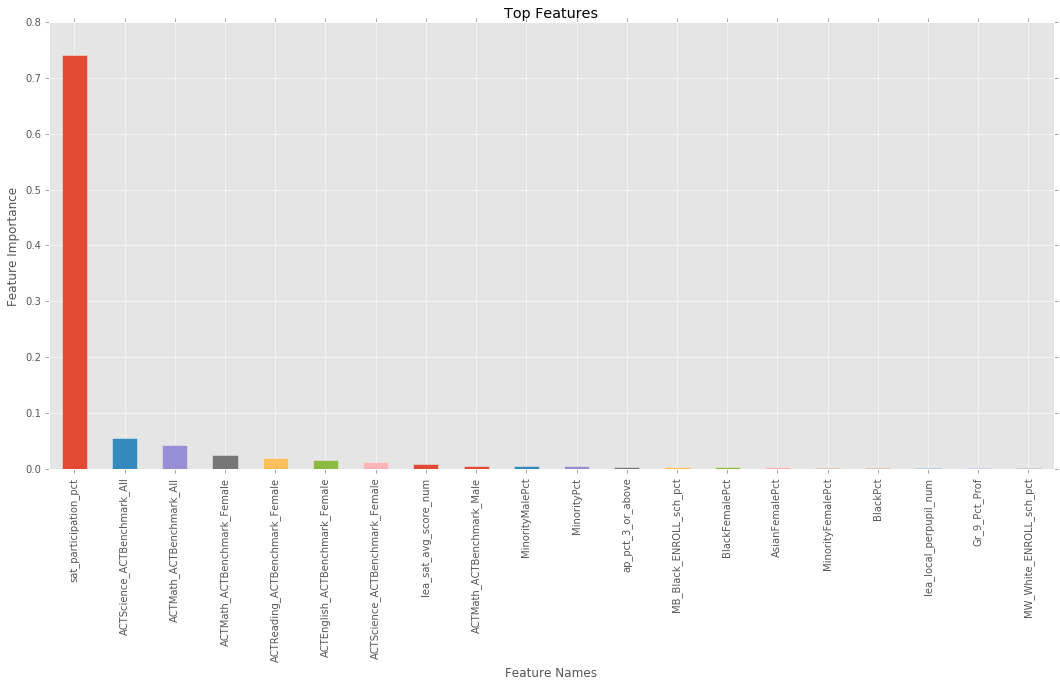

In [11]:
# Examine categorical variables of interest  
import matplotlib.pyplot as plt
%matplotlib inline

#Plot the model's feature importances
# REFERENCE:  Eric Larson, https://github.com/eclarson/DataMiningNotebooks
plt.style.use('ggplot')

wt_plt_df = linreg_ft_imp_df.head(20)

weights = pd.Series(wt_plt_df['weights'].values,index=wt_plt_df['feature_names'])
ax = weights.plot(kind='bar', figsize=(18,8))

ax.set_title("Top Features")
ax.set_ylabel("Feature Importance")
ax.set_xlabel("Feature Names")
plt.show()